## Overview

3 MNIST users (2 with consistent labels, 1 with flipped labels)

Using user embedding model with embeddings of dimension 1 to learn weights

Should learn negative embedding for user 3 and positive embeddings for user 1 and 2 (or vice-versa)

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import json
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

In [2]:
data_dir = "/data/ddmg/redditlanguagemodeling/results/mnist"

In [22]:
# for accuracy results
def collect_results(base_dir):
    collect_results = []
    for sub_dir in os.listdir(base_dir):
        pred_lr = sub_dir.split("_")[1]
        meta_lr = sub_dir.split("_")[3]
        for seed in [42, 43, 44]:
            result_dir = os.path.join(base_dir, sub_dir, str(seed))
            if os.path.exists(os.path.join(result_dir, "test_results.json")):
                with open(os.path.join(result_dir, "test_results.json"), "rb") as f:
                    results = json.load(f)
                for user in [1, 2, 3]:
                    user_acc = results[str(user)]["test_accuracy"]
                    collect_results.append({"user": user, "accuracy": user_acc, "seed": seed,
                                           "pred_lr": pred_lr, "meta_lr": meta_lr})
        result_df = pd.DataFrame(collect_results)
    return result_df

In [23]:
def collect_results_single_param(base_dir, seeds):
    collect_results = []
    for seed in seeds:
        result_dir = os.path.join(base_dir, str(seed))
        with open(os.path.join(result_dir, "test_results.json"), "rb") as f:
            results = json.load(f)
        for user in [1, 2, 3]:
            user_acc = results[str(user)]["test_accuracy"]
            collect_results.append({"user": user, "accuracy": user_acc, "seed": seed})
    result_df = pd.DataFrame(collect_results)
    return result_df

In [35]:
def collect_details(base_dir, seeds):
    collect_losses = {"loss": [], "step": [], "user": [], "seed": []}
    collect_ws = []
    collect_embeds = []
    num_users = 3
    for seed in seeds:
        result_dir = os.path.join(base_dir, str(seed))
        user_step_losses = np.load(os.path.join(result_dir, "step_user_losses.npy"))
        num_steps = len(user_step_losses)
        losses_flat = user_step_losses.flatten(order='F')
        collect_losses["loss"] += list(losses_flat)
        collect_losses["step"] += list(np.array([[np.arange(num_steps)] * num_users]).flatten())
        collect_losses["user"] += list(np.array([["user_{}".format(i)] * num_steps for i in range(num_users)]).flatten())
        collect_losses["seed"] += [seed] * len(losses_flat)
        weight_matrices = np.load(os.path.join(result_dir, "user_weight_matrices.npy"))
        embeds = np.load(os.path.join(result_dir, "user_embeds.npy"))
        collect_ws.append(weight_matrices)
        collect_embeds.append(embeds)
    return collect_losses, collect_ws, collect_embeds

In [71]:
def collect_details2(base_dir, seeds):
    collect_losses = {"loss": [], "step": [], "user": [], "seed": []}
    collect_ws = []
    collect_embeds = []
    collect_embed_grads = []
    collect_w_grads = []
    num_users = 3
    for seed in seeds:
        result_dir = os.path.join(base_dir, str(seed))
        user_step_losses = np.load(os.path.join(result_dir, "step_user_losses.npy"))
        num_steps = len(user_step_losses)
        losses_flat = user_step_losses.flatten(order='F')
        collect_losses["loss"] += list(losses_flat)
        collect_losses["step"] += list(np.array([[np.arange(num_steps)] * num_users]).flatten())
        collect_losses["user"] += list(np.array([["user_{}".format(i)] * num_steps for i in range(num_users)]).flatten())
        collect_losses["seed"] += [seed] * len(losses_flat)
        weight_matrices = np.load(os.path.join(result_dir, "user_weight_matrices.npy"))
        embeds = np.load(os.path.join(result_dir, "user_embeds.npy"))
        w_grads = np.load(os.path.join(result_dir, "weight_gradients.npy"))
        embeds_grads = np.load(os.path.join(result_dir, "user_embeds_gradients.npy"))
        collect_ws.append(weight_matrices)
        collect_embeds.append(embeds)
        collect_w_grads.append(w_grads)
        collect_embed_grads.append(embeds_grads)
    return collect_losses, collect_ws, collect_embeds, collect_w_grads, collect_embed_grads

In [135]:
def collect_details3(base_dir, seeds):
    collect_losses = {"loss": [], "step": [], "user": [], "seed": []}
    collect_ws = []
    collect_embeds = []
    collect_embed_grads = []
    collect_w_grads = []
    collect_users = []
    num_users = 3
    for seed in seeds:
        result_dir = os.path.join(base_dir, str(seed))
        user_step_losses = np.load(os.path.join(result_dir, "step_user_losses.npy"))
        num_steps = len(user_step_losses)
        losses_flat = user_step_losses.flatten(order='F')
        collect_losses["loss"] += list(losses_flat)
        collect_losses["step"] += list(np.array([[np.arange(num_steps)] * num_users]).flatten())
        collect_losses["user"] += list(np.array([["user_{}".format(i)] * num_steps for i in range(num_users)]).flatten())
        collect_losses["seed"] += [seed] * len(losses_flat)
        weight_matrices = np.load(os.path.join(result_dir, "user_weight_matrices.npy"))
        embeds = np.load(os.path.join(result_dir, "user_embeds.npy"))
        w_grads = np.load(os.path.join(result_dir, "weight_gradients.npy"))
        embeds_grads = np.load(os.path.join(result_dir, "user_embeds_gradients.npy"))
        users = np.load(os.path.join(result_dir, "train_users.npy"))
        collect_ws.append(weight_matrices)
        collect_embeds.append(embeds)
        collect_w_grads.append(w_grads)
        collect_embed_grads.append(embeds_grads)
        collect_users.append(users)
    return collect_losses, collect_ws, collect_embeds, collect_w_grads, collect_embed_grads, collect_users

In [117]:
def collect_train_times(base_dir, seeds):
    times = []
    sps = []
    for seed in seeds:
        result_dir = os.path.join(base_dir, str(seed))
        with open(os.path.join(result_dir, "trainer_state.json"), "rb") as f:
            t_state = json.load(f)
        times.append(t_state["log_history"][-1]["train_runtime"])
        sps.append(t_state["log_history"][-1]["train_samples_per_second"])
    return times, sps

### First Weighting Scheme
* weight = e^-(cosine distance)

Results where weights are normalized

In [8]:
results1 = collect_results(os.path.join(data_dir, "user_embed_train"))

In [11]:
agg_df = results1.groupby(["pred_lr", "meta_lr"]).agg(["mean", "std"])
agg_df

user       accuracy           seed     
                mean  std      mean       std mean  std
pred_lr meta_lr                                        
0.0001  0.001      2  1.0  0.676667  0.300056   42  0.0
        0.01       2  1.0  0.440000  0.168226   42  0.0
        0.1        2  1.0  0.440000  0.168226   42  0.0
        1          2  1.0  0.493333  0.134288   42  0.0
0.001   0.001      2  1.0  0.470000  0.096436   42  0.0
        0.01       2  1.0  0.460000  0.105830   42  0.0
        0.1        2  1.0  0.460000  0.108167   42  0.0
        1          2  1.0  0.460000  0.105830   42  0.0
1e-05   0.001      2  1.0  0.443333  0.011547   42  0.0
        0.01       2  1.0  0.456667  0.035119   42  0.0
        0.1        2  1.0  0.566667  0.161658   42  0.0
        1          2  1.0  0.936667  0.075719   42  0.0

Results where loss is normalized (sanity check) --> i.e., divide by batch size when computing loss not when computing weights

In [13]:
results2 = collect_results(os.path.join(data_dir, "user_embed_train_2_check_norm"))

In [14]:
agg_df = results2.groupby(["pred_lr", "meta_lr"]).agg(["mean", "std"])
agg_df

user       accuracy           seed     
                mean  std      mean       std mean  std
pred_lr meta_lr                                        
0.0001  0.001      2  1.0  0.593333  0.240069   42  0.0
        0.01       2  1.0  0.600000  0.095394   42  0.0
        0.1        2  1.0  0.600000  0.095394   42  0.0
        1          2  1.0  0.586667  0.085049   42  0.0
0.001   0.001      2  1.0  0.533333  0.289194   42  0.0
        0.01       2  1.0  0.533333  0.289194   42  0.0
        0.1        2  1.0  0.600000  0.173494   42  0.0
        1          2  1.0  0.943333  0.055076   42  0.0
1e-05   0.001      2  1.0  0.576667  0.136504   42  0.0
        0.01       2  1.0  0.556667  0.169214   42  0.0
        0.1        2  1.0  0.573333  0.115470   42  0.0
        1          2  1.0  0.556667  0.169214   42  0.0

### Second Weighting Scheme
* weight = cosine similarity

In [15]:
results3 = collect_results(os.path.join(data_dir, "user_embed_train_cos_sim"))

In [16]:
agg_df = results3.groupby(["pred_lr", "meta_lr"]).agg(["mean", "std"])
agg_df

user       accuracy           seed     
                mean  std      mean       std mean  std
pred_lr meta_lr                                        
0.0001  0.001      2  1.0  0.553333  0.167730   42  0.0
        0.01       2  1.0  0.600000  0.095394   42  0.0
        0.1        2  1.0  0.586667  0.085049   42  0.0
        1          2  1.0  0.970000  0.010000   42  0.0
0.001   0.001      2  1.0  0.480000  0.290000   42  0.0
        0.01       2  1.0  0.480000  0.290000   42  0.0
        0.1        2  1.0  0.600000  0.173494   42  0.0
        1          2  1.0  0.773333  0.306159   42  0.0
1e-05   0.001      2  1.0  0.550000  0.180831   42  0.0
        0.01       2  1.0  0.560000  0.164621   42  0.0
        0.1        2  1.0  0.550000  0.180831   42  0.0
        1          2  1.0  0.556667  0.169214   42  0.0

In [40]:
# examine loss curves for specific runs
results4 = collect_results_single_param(os.path.join(data_dir, "user_embed_train_cos_sim", "predLR_0.0001_metaLR_1"), [42])

In [41]:
results4

,user,accuracy,seed
0,1,0.97,42
1,2,0.98,42
2,3,0.96,42


In [55]:
losses, wms, embeds = collect_details(os.path.join(data_dir, "user_embed_train_cos_sim", "predLR_0.0001_metaLR_0.01"), [42])

In [62]:
loss_df = pd.DataFrame(losses)

<AxesSubplot:xlabel='step', ylabel='loss'>

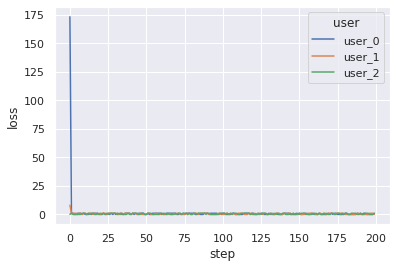

In [64]:
sns.lineplot(data=loss_df, x="step", y="loss", hue="user")

<AxesSubplot:xlabel='step', ylabel='loss'>

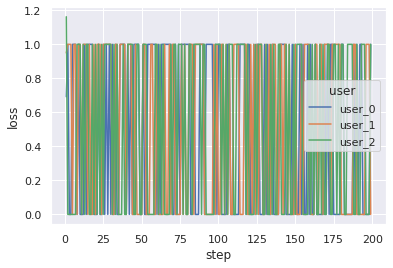

In [66]:
loss2 = loss_df[loss_df["step"] > 0]
sns.lineplot(data=loss2, x="step", y="loss", hue="user")

In [60]:
wm_final = np.load(os.path.join(data_dir, "user_embed_train_cos_sim", "predLR_0.0001_metaLR_0.01", "42", "final_user_weight_matrix.npy"))

In [61]:
wm_final

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [58]:
embeds[0][-1]

array([[1.],
       [1.],
       [1.]])

In [65]:
# this makes no sense! --> there's definitely a bug
wms[0][0]

array([[ 1.        , -0.99999988, -1.        ],
       [-0.99999988,  1.        ,  1.        ],
       [-1.        ,  1.        ,  1.        ]])

### Directly learning user embeddings and taking dot product to get weight matrix

In [69]:
results4 = collect_results_single_param(os.path.join(data_dir, "user_weight_train_with_user_embeds"), [42])

In [70]:
results4

,user,accuracy,seed
0,1,0.53,42
1,2,0.70,42
2,3,0.59,42


In [89]:
loss, weights, embeds, weight_grads, embeds_grads = collect_details2(os.path.join(data_dir, "user_weight_train_with_user_embeds"), [42])

In [74]:
loss_df = pd.DataFrame(loss)

<AxesSubplot:xlabel='step', ylabel='loss'>

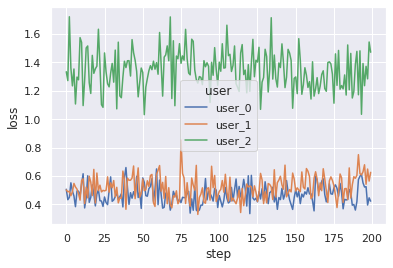

In [75]:
sns.lineplot(data=loss_df, x="step", y="loss", hue="user")

In [103]:
# manually calculate expected grads
g1 = 2 * weight_grads[0][0][0, 0] + sum(weight_grads[0][0][0, 1:]) + weight_grads[0][0][1, 0] + weight_grads[0][0][2, 0]
g2 = 2 * weight_grads[0][0][1, 1] + weight_grads[0][0][1, 2] + weight_grads[0][0][1, 0] + weight_grads[0][0][0, 1] + weight_grads[0][0][2, 1]
g3 = 2 * weight_grads[0][0][2, 2] + sum(weight_grads[0][0][2, :2]) + weight_grads[0][0][0, 2] + weight_grads[0][0][1, 2]
print(g1, g2, g3)

-0.05814856290817261 0.059841543436050415 -0.0016929805278778076


In [101]:
g1 = sum(weight_grads[0][0][0, :]) + weight_grads[0][0][1, 0] + weight_grads[0][0][2, 0]
g1

0.1071251928806305

In [76]:
weight_grads

[array([[[-0.16527376, -0.1361149 ,  0.30138865],
         [-0.15686384, -0.1726298 ,  0.32949364],
         [ 0.26398903,  0.36858624, -0.63257527]],
 
        [[-0.18112117, -0.16777012,  0.3455691 ],
         [-0.14039233, -0.25340065,  0.38877517],
         [ 0.2043502 ,  0.25418925, -0.45350599]],
 
        [[-0.14468996, -0.13917007,  0.28522363],
         [-0.0989774 , -0.16033739,  0.25973356],
         [ 0.26570854,  0.43972483, -0.7064842 ]],
 
        ...,
 
        [[-0.16719182, -0.27116656,  0.43405691],
         [-0.13454981, -0.193532  ,  0.3239902 ],
         [ 0.30713329,  0.34841889, -0.64383042]],
 
        [[-0.22682889, -0.11932597,  0.33513832],
         [-0.18312216, -0.15237546,  0.32836223],
         [ 0.34168971,  0.36743501, -0.69841862]],
 
        [[-0.16804577, -0.20046885,  0.36515537],
         [-0.19317582, -0.16804023,  0.35509712],
         [ 0.29482406,  0.38357916, -0.67366242]]])]

In [77]:
embeds_grads

[array([[[-5.81485629e-02],
         [ 5.98415434e-02],
         [-1.69301033e-03]],
 
        [[-1.15527049e-01],
         [-1.63583323e-01],
         [ 2.75871217e-01]],
 
        [[ 2.04132497e-02],
         [ 1.39476359e-01],
         [-1.59136057e-01]],
 
        [[-2.95346975e-03],
         [ 8.64607096e-03],
         [-5.55497408e-03]],
 
        [[-2.05196425e-01],
         [ 1.34751230e-01],
         [ 7.79579282e-02]],
 
        [[ 2.99625695e-02],
         [ 1.14239991e-01],
         [-1.44478619e-01]],
 
        [[-1.05589449e-01],
         [ 3.29835415e-02],
         [ 7.79788494e-02]],
 
        [[-1.61464870e-01],
         [-5.56201413e-02],
         [ 2.24800318e-01]],
 
        [[ 1.32588893e-01],
         [-1.18106931e-01],
         [-2.51721740e-02]],
 
        [[-7.02482983e-02],
         [-1.93908378e-01],
         [ 2.66060323e-01]],
 
        [[ 1.84861302e-01],
         [-7.53832459e-02],
         [-1.25220120e-01]],
 
        [[-4.42878082e-02],
         [-1.58

In [78]:
weights

[array([[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[1.0201    , 0.99989998, 1.0201    ],
         [0.99989998, 0.98010004, 0.99989998],
         [1.0201    , 0.99989998, 1.0201    ]],
 
        [[1.03970432, 1.01424241, 1.0223099 ],
         [1.01424241, 0.98940402, 0.99727392],
         [1.0223099 , 0.99727392, 1.00520647]],
 
        ...,
 
        [[0.92783964, 1.0199604 , 0.99458468],
         [1.0199604 , 1.1212275 , 1.09333229],
         [0.99458468, 1.09333229, 1.06613111]],
 
        [[0.92784351, 1.02356315, 0.99242425],
         [1.02356315, 1.12915754, 1.09480619],
         [0.99242425, 1.09480619, 1.06149995]],
 
        [[0.92823869, 1.02663422, 0.99079686],
         [1.02663422, 1.13546002, 1.09582376],
         [0.99079686, 1.09582376, 1.05757117]]])]

In [79]:
embeds

[array([[[1.        ],
         [1.        ],
         [1.        ]],
 
        [[1.00999999],
         [0.99000001],
         [1.00999999]],
 
        [[1.01965892],
         [0.99468791],
         [1.00259984]],
 
        [[1.02603734],
         [0.99352169],
         [1.00083852]],
 
        [[1.03139198],
         [0.99234194],
         [0.99949741]],
 
        [[1.03842449],
         [0.98866749],
         [0.99709803]],
 
        [[1.04380167],
         [0.98366994],
         [0.99731439]],
 
        [[1.05011868],
         [0.97875094],
         [0.9964202 ]],
 
        [[1.05745029],
         [0.97544068],
         [0.99315321]],
 
        [[1.06152475],
         [0.97455436],
         [0.99054414]],
 
        [[1.06606984],
         [0.97642595],
         [0.98601419]],
 
        [[1.06738615],
         [0.97903442],
         [0.98323381]],
 
        [[1.06910324],
         [0.98158038],
         [0.98016584]],
 
        [[1.07046461],
         [0.98316032],
         [0.978074

### 2-D Embeddings - Learned Directly with Weight Matrix Produced by Dot Product

In [80]:
results5 = collect_results_single_param(os.path.join(data_dir, "user_weight_train_with_user_embeds_dim_2"), [42])

In [81]:
results5

,user,accuracy,seed
0,1,0.63,42
1,2,0.86,42
2,3,0.44,42


In [82]:
loss, weights, embeds, weight_grads, embeds_grads = collect_details2(os.path.join(data_dir, "user_weight_train_with_user_embeds_dim_2"), [42])

In [83]:
loss_df = pd.DataFrame(loss)

<AxesSubplot:xlabel='step', ylabel='loss'>

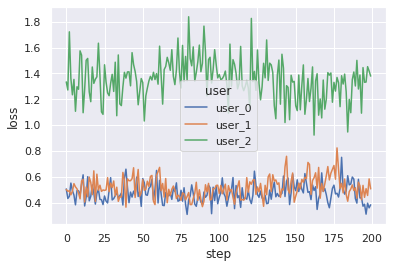

In [85]:
sns.lineplot(data=loss_df, x="step", y="loss", hue="user")

In [86]:
weight_grads

[array([[[-0.08263688, -0.06805745,  0.15069433],
         [-0.07843192, -0.0863149 ,  0.16474682],
         [ 0.13199452,  0.18429312, -0.31628764]],
 
        [[-0.09056056, -0.0838851 ,  0.17278458],
         [-0.07019626, -0.12670028,  0.19438767],
         [ 0.10217518,  0.12709461, -0.22675309]],
 
        [[-0.07234492, -0.06958497,  0.14261171],
         [-0.04948862, -0.08016872,  0.12986673],
         [ 0.1328543 ,  0.21986236, -0.35324213]],
 
        ...,
 
        [[-0.10316135, -0.03846128,  0.15314557],
         [-0.0556283 , -0.04877872,  0.11716351],
         [ 0.15413597,  0.2842052 , -0.50846761]],
 
        [[-0.06288308, -0.05117544,  0.128281  ],
         [-0.08437061, -0.0253101 ,  0.11836397],
         [ 0.28892723,  0.10452054, -0.42746437]],
 
        [[-0.0958728 , -0.04706946,  0.15787038],
         [-0.09967765, -0.04579903,  0.16022772],
         [ 0.20194092, -0.01381549, -0.19187127]]])]

In [87]:
embeds_grads

[array([[[-0.02907428, -0.02907428],
         [ 0.02992077,  0.02992077],
         [-0.00084651, -0.00084651]],
 
        [[-0.05776355, -0.05776355],
         [-0.08179166, -0.08179166],
         [ 0.13793567,  0.13793567]],
 
        [[ 0.01020678,  0.01020678],
         [ 0.06973813,  0.06973813],
         [-0.07956827, -0.07956827]],
 
        ...,
 
        [[-0.01920673, -0.01920673],
         [ 0.17570606,  0.17570606],
         [-0.19702613, -0.19702613]],
 
        [[ 0.11335588,  0.11335588],
         [ 0.0193335 ,  0.0193335 ],
         [-0.14083625, -0.14083625]],
 
        [[-0.02028801, -0.02028801],
         [-0.11316629, -0.11316629],
         [ 0.16191949,  0.16191949]]])]

In [88]:
embeds

[array([[[1.        , 1.        ],
         [1.        , 1.        ],
         [1.        , 1.        ]],
 
        [[1.00999999, 1.00999999],
         [0.99000001, 0.99000001],
         [1.00999987, 1.00999987]],
 
        [[1.01965892, 1.01965892],
         [0.99468791, 0.99468791],
         [1.00259972, 1.00259972]],
 
        ...,
 
        [[0.97515666, 0.97515666],
         [1.17372   , 1.17372   ],
         [0.95165181, 0.95165181]],
 
        [[0.97804654, 0.97804654],
         [1.17624021, 1.17624021],
         [0.94867676, 0.94867676]],
 
        [[0.97982192, 0.97982192],
         [1.17844748, 1.17844748],
         [0.94639134, 0.94639134]]])]

### Updating weights based on single user's performance at a time

In [111]:
results6 = collect_results_single_param(os.path.join(data_dir, "user_weight_train_with_user_embeds_inner_loop_meta_step"), [42, 43, 44])

In [112]:
results6

,user,accuracy,seed
0,1,0.58,42
1,2,0.78,42
2,3,0.24,42
3,1,0.76,43
4,2,0.53,43
5,3,0.37,43
6,1,0.62,44
7,2,0.75,44
8,3,0.19,44


In [114]:
loss, weights, embeds, weight_grads, embeds_grads = collect_details2(os.path.join(data_dir, "user_weight_train_with_user_embeds_inner_loop_meta_step"), [42, 43, 44])

In [115]:
loss_df = pd.DataFrame(loss)

<AxesSubplot:xlabel='step', ylabel='loss'>

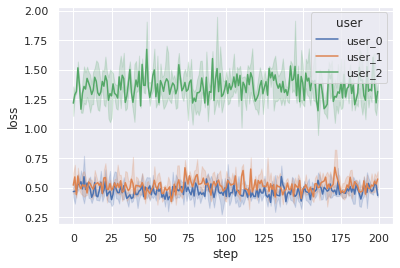

In [116]:
sns.lineplot(data=loss_df, x="step", y="loss", hue="user")

In [110]:
weight_grads[0].shape

(200, 3, 3, 3)

In [118]:
times, sps = collect_train_times(os.path.join(data_dir, "user_weight_train_with_user_embeds_inner_loop_meta_step"), [42, 43, 44])

In [119]:
np.mean(times), np.std(times)

(3740.8147666666664, 90.9685455191823)

In [122]:
times

[3612.7673, 3815.5995, 3794.0775]

In [120]:
3740 / 60

62.333333333333336

In [121]:
sps

[0.166, 0.157, 0.158]

In [ ]:
# check with not printing

In [128]:
results7 = collect_results_single_param(os.path.join(data_dir, "user_weight_train_with_user_embeds_inner_loop_meta_step_no_print"), [42, 43, 44])

In [129]:
results7

,user,accuracy,seed
0,1,0.69,42
1,2,0.73,42
2,3,0.26,42
3,1,0.45,43
4,2,0.82,43
5,3,0.51,43
6,1,0.70,44
7,2,0.67,44
8,3,0.59,44


In [130]:
times, sps = collect_train_times(os.path.join(data_dir, "user_weight_train_with_user_embeds_inner_loop_meta_step_no_print"), [42, 43, 44])

In [131]:
times

[4457.7553, 4413.2968, 4581.9727]

In [133]:
4457/60

74.28333333333333

In [132]:
sps

[0.135, 0.136, 0.131]

In [137]:
loss, weights, embeds, weight_grads, embeds_grads, train_users = collect_details3(os.path.join(data_dir, "user_weight_train_with_user_embeds_inner_loop_meta_step_no_print"), [42, 43, 44])

In [138]:
weights

[array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.0201    , 1.0201    , 0.99989998],
          [1.0201    , 1.0201    , 0.99989998],
          [0.99989998, 0.99989998, 0.98010004]],
 
         [[1.03751338, 1.03892422, 0.99834609],
          [1.03892422, 1.04033697, 0.99970365],
          [0.99834609, 0.99970365, 0.96065742]]],
 
 
        [[[1.03432   , 1.03664184, 0.99805319],
          [1.03664184, 1.0389688 , 1.00029361],
          [0.99805319, 1.00029361, 0.96305799]],
 
         [[1.03645527, 1.03891373, 0.99801695],
          [1.03891373, 1.04137802, 1.00038421],
          [0.99801695, 1.00038421, 0.96100414]],
 
         [[1.03137887, 1.03510737, 0.99756914],
          [1.03510737, 1.03884923, 1.0011754 ],
          [0.99756914, 1.0011754 , 0.96486771]]],
 
 
        [[[1.02923524, 1.03455496, 0.99684483],
          [1.03455496, 1.03990221, 1.00199711],
          [0.996

In [139]:
embeds

[array([[[[1.        ],
          [1.        ],
          [1.        ]],
 
         [[1.00999999],
          [1.00999999],
          [0.99000001]],
 
         [[1.01858401],
          [1.01996911],
          [0.98013133]]],
 
 
        [[[1.01701522],
          [1.0192982 ],
          [0.98135519]],
 
         [[1.0180645 ],
          [1.02047932],
          [0.98030818]],
 
         [[1.01556826],
          [1.01923954],
          [0.9822768 ]]],
 
 
        [[[1.0145123 ],
          [1.01975596],
          [0.98258525]],
 
         [[1.0150317 ],
          [1.02125561],
          [0.98159665]],
 
         [[1.01712632],
          [1.02475882],
          [0.97873902]]],
 
 
        ...,
 
 
        [[[0.98097849],
          [1.19282758],
          [0.90695667]],
 
         [[0.97328734],
          [1.19568598],
          [0.90889376]],
 
         [[0.96683085],
          [1.19865572],
          [0.91009438]]],
 
 
        [[[0.95971215],
          [1.20036149],
          [0.91258317]]

In [143]:
train_users

[array([[0., 1., 2.],
        [1., 2., 0.],
        [0., 1., 2.],
        [1., 2., 0.],
        [0., 1., 2.],
        [1., 0., 2.],
        [1., 0., 2.],
        [2., 1., 0.],
        [0., 1., 2.],
        [2., 1., 0.],
        [0., 2., 1.],
        [0., 2., 1.],
        [1., 2., 0.],
        [0., 2., 1.],
        [2., 1., 0.],
        [1., 2., 0.],
        [1., 0., 2.],
        [0., 1., 2.],
        [0., 1., 2.],
        [2., 0., 1.],
        [2., 0., 1.],
        [0., 1., 2.],
        [1., 2., 0.],
        [1., 2., 0.],
        [1., 0., 2.],
        [1., 2., 0.],
        [0., 2., 1.],
        [2., 1., 0.],
        [0., 2., 1.],
        [2., 0., 1.],
        [2., 0., 1.],
        [0., 2., 1.],
        [0., 1., 2.],
        [0., 1., 2.],
        [2., 1., 0.],
        [1., 0., 2.],
        [2., 0., 1.],
        [0., 2., 1.],
        [0., 2., 1.],
        [0., 2., 1.],
        [0., 2., 1.],
        [2., 0., 1.],
        [0., 1., 2.],
        [0., 2., 1.],
        [0., 2., 1.],
        [0

In [142]:
weight_grads

[array([[[[-0.21544583, -0.1751249 ,  0.39057073],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [-0.06520912, -0.23334715,  0.30458772],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.33910027,  0.41487235, -0.78413892]]],
 
 
        [[[ 0.        ,  0.        ,  0.        ],
          [-0.16403008, -0.15104434,  0.32687482],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.32299709,  0.23010892, -0.57497555]],
 
         [[-0.1087679 , -0.17303646,  0.29200202],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]]],
 
 
        [[[-0.15612316, -0.12567367,  0.29162389],
       

In [140]:
embeds_grads

[array([[[[-0.21544583],
          [-0.1751249 ],
          [ 0.39057073]],
 
         [[-0.06586121],
          [-0.23568058],
          [ 0.30763361]],
 
         [[ 0.3323628 ],
          [ 0.40662938],
          [-0.7685591 ]]],
 
 
        [[[-0.16719556],
          [-0.15395923],
          [ 0.33318293]],
 
         [[ 0.31663668],
          [ 0.22557765],
          [-0.56365317]],
 
         [[-0.11046122],
          [-0.17573033],
          [ 0.29654798]]],
 
 
        [[[-0.15838887],
          [-0.12749748],
          [ 0.29585603]],
 
         [[-0.20315324],
          [-0.32589635],
          [ 0.54913646]],
 
         [[ 0.4790687 ],
          [ 0.1871101 ],
          [-0.69376624]]],
 
 
        ...,
 
 
        [[[-0.126993  ],
          [-0.12322225],
          [ 0.29941931]],
 
         [[-0.14222877],
          [-0.14128876],
          [ 0.33817643]],
 
         [[ 0.39620587],
          [ 0.34621638],
          [-0.87689638]]],
 
 
        [[[ 0.31194028],
          